In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from lightgbm import LGBMClassifier
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [63]:
df = pd.read_csv('/content/sample_data/bank-additional-full.csv', delimiter=';', na_values='?')

In [64]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [65]:
print(df.shape)
print(df.isnull().sum())

(41188, 21)
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [66]:
df = df.rename(columns={'default': 'creditDefault', 'housing': 'houseLoan', 'loan':'personalLoan', 'contact': 'contactType',
                       'month': 'contactMonth', 'day': 'contactDay', 'duraction':'contactDuration', 'emp.var.rate':'emp_var_rate',
                        'cons.conf.idx':'con_confi_idx','cons.price.idx':'cons_price_idx','nr.employed':'noOfEmployee','y':'target'})

Categorical Features

In [67]:
object_columns = df.select_dtypes(include='object').columns

In [68]:
# convert age into two section as in old people and adult
def categorize_age(age_column):
    categories = []
    for age in age_column:
        if age >= 65:   #oldAge
            categories.append(1)
        elif age < 65: #adult
            categories.append(2)
    return categories

age = categorize_age(df['age'])
df['ageCategory'] = age

#converted seconds to days
def seconds_to_days(seconds):
    days = seconds / 60
    return days
minutes = seconds_to_days(df['duration'])
df['minutes'] = minutes

# convert previous contacted 1 as 'yes' and 0 as 'no'
def categorize_pervious(col):
    categories = []
    for c in col:
        if c != 999:
            categories.append(1)
        elif c == 999:
            categories.append(0)
    return categories

pdays = categorize_pervious(df['pdays'])
df = df.drop(['duration', 'age', 'pdays'], axis=1)
df['pdays'] = pdays

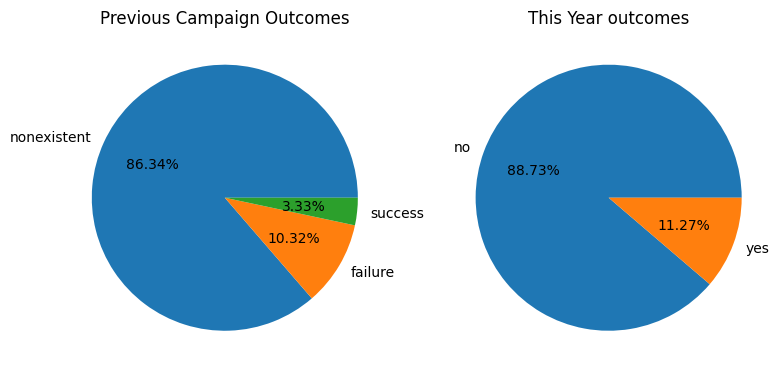

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
label_counts = df['target'].value_counts()
out_counts = df['poutcome'].value_counts()
axes[0].pie(out_counts, labels=out_counts.index, autopct='%1.2f%%')
axes[0].set_title('Previous Campaign Outcomes')
axes[1].pie(label_counts, labels=label_counts.index, autopct='%1.2f%%')
axes[1].set_title('This Year outcomes')
plt.tight_layout()
plt.show()

In [70]:
df.head(10)

,job,marital,education,creditDefault,houseLoan,personalLoan,contactType,contactMonth,day_of_week,campaign,...,poutcome,emp_var_rate,cons_price_idx,con_confi_idx,euribor3m,noOfEmployee,target,ageCategory,minutes,pdays
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,4.350000,0
1,services,married,high.school,unknown,no,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,2.483333,0
2,services,married,high.school,no,yes,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,3.766667,0
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,2.516667,0
4,services,married,high.school,no,no,yes,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,5.116667,0
5,services,married,basic.9y,unknown,no,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,3.300000,0
6,admin.,married,professional.course,no,no,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,2.316667,0
7,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,3.616667,0
8,technician,single,professional.course,no,yes,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,6.333333,0
9,services,single,high.school,no,yes,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2,0.833333,0


In [71]:
columns_to_encode = ['marital', 'creditDefault','houseLoan','job','personalLoan','contactType',
                     'contactMonth','day_of_week','poutcome']
df = pd.get_dummies(df, columns=columns_to_encode)
print(df.shape)

(41188, 57)


In [72]:
def labels_prediction(label):
    category = []
    for c in label:
        if c == 'yes':
            category.append(1)
        elif c == 'no':
            category.append(0)
    return category
labels = pd.DataFrame(labels_prediction(df['target']))

In [73]:
labels = np.ravel(labels)
target = pd.DataFrame(labels)
features = df.drop(columns=['target','education'])
print(features.shape, target.shape)

(41188, 55) (41188, 1)


In [74]:
x_train,x_test,y_train,y_test = train_test_split(features,target, test_size=0.2, random_state=42)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(32950, 55) (8238, 55) (32950, 1) (8238, 1)


Linear Models

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [76]:
class_counts = y_train.value_counts()
y_train = np.array(y_train)
y_train = np.ravel(y_train)

In [77]:

class_weights = {0: (round(1 - ((class_counts[0] / (class_counts[1]*10))),2)), 1: round((class_counts[0] / (class_counts[1]*10)),2)}
model = LogisticRegression(random_state=42, class_weight=class_weights, max_iter=1000)
model.fit(x_train, y_train)

model_1 = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model_1.fit(x_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Type 1 :  **Linear model with assigned class weights**
- High Accuracy and Low Recall
- Helps in predicting true positive and true negative but might miss some positive cases.

In [78]:
num_iterations = 5
for iteration in range(num_iterations):
    model.fit(x_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(x_test)

    # Calculate and store recall score
    recall = recall_score(y_test, y_pred)
    print(f"Iteration {iteration + 1} - Recall: {recall:.4f}")

# Evaluate the final model
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Final Model - Accuracy:", accuracy)
print("\nFinal Model - Classification Report:\n", report)
print("\nFinal Model - Confusion Matrix:\n", confusion)


Iteration 1 - Recall: 0.7594
Iteration 2 - Recall: 0.7594
Iteration 3 - Recall: 0.7594
Iteration 4 - Recall: 0.7594
Iteration 5 - Recall: 0.7594
Final Model - Accuracy: 0.8941490653071134

Final Model - Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      7303
           1       0.52      0.76      0.62       935

    accuracy                           0.89      8238
   macro avg       0.75      0.84      0.78      8238
weighted avg       0.92      0.89      0.90      8238


Final Model - Confusion Matrix:
 [[6656  647]
 [ 225  710]]


**Type 2: Linear model with assign weights**
- Low Accuracy and High recall
- Helps in predicting more false positive values which reduces the chances of losing even a vital subscriber.

In [79]:
num_iterations = 5


for iteration in range(num_iterations):
    model_1.fit(x_train, y_train)

    # Make predictions on the test data
    y_pred_1 = model_1.predict(x_test)

    # Calculate and store recall score
    recall_1 = recall_score(y_test, y_pred_1)

    print(f"Iteration {iteration + 1} - Recall: {recall_1:.4f}")

# Evaluate the final model
y_pred_1 = model_1.predict(x_test)
accuracy_1 = accuracy_score(y_test, y_pred_1)
report_1 = classification_report(y_test, y_pred_1)
confusion_1 = confusion_matrix(y_test, y_pred_1)

print("Final Model - Accuracy:", accuracy_1)
print("\nFinal Model - Classification Report:\n", report_1)
print("\nFinal Model - Confusion Matrix:\n", confusion_1)

Iteration 1 - Recall: 0.8845
Iteration 2 - Recall: 0.8845
Iteration 3 - Recall: 0.8845
Iteration 4 - Recall: 0.8845
Iteration 5 - Recall: 0.8845
Final Model - Accuracy: 0.8580966253945133

Final Model - Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      7303
           1       0.44      0.88      0.59       935

    accuracy                           0.86      8238
   macro avg       0.71      0.87      0.75      8238
weighted avg       0.92      0.86      0.88      8238


Final Model - Confusion Matrix:
 [[6242 1061]
 [ 108  827]]


**ii). Ensemble Model**

In [80]:
from sklearn.ensemble import RandomForestClassifier

Type 1: RF assigned without class weigths
- Performs poorly compare to Linear model.
- Accuracy is higher compare to linear model
- Overall, F1 score and recall values are poor and no prediction is feasible.

In [81]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
scoring_metrics = ['accuracy', 'recall', 'f1']
cv_results = cross_validate(rf_classifier, x_train, y_train, cv=5, scoring=scoring_metrics)
accuracy_scores = cv_results['test_accuracy']
recall_scores = cv_results['test_recall']
recall_scores= cv_results['test_recall']
F1_scores= cv_results['test_f1']

print("Cross-Validation Accuracy Scores:", accuracy_scores)
print("Mean CV Accuracy:", np.mean(accuracy_scores))
print("Cross-Validation Recall Scores:", recall_scores)
print("Mean CV Recall:", np.mean(recall_scores))
print("Cross-Validation F1 Scores:", F1_scores)
print("Mean CV F1 Score:", np.mean(F1_scores))

Cross-Validation Accuracy Scores: [0.90955994 0.91198786 0.9124431  0.90819423 0.91487102]
Mean CV Accuracy: 0.9114112291350531
Cross-Validation Recall Scores: [0.43859649 0.46018893 0.44129555 0.42780027 0.4439946 ]
Mean CV Recall: 0.44237516869095816
Cross-Validation F1 Scores: [0.52166934 0.54041204 0.53127539 0.51170299 0.53978671]
Mean CV F1 Score: 0.5289692937661707


In [82]:
class_weights = {0: 1, 1: 2}
rf_classifier_1 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
scoring_metrics = ['accuracy', 'recall', 'f1']
cv_results_1 = cross_validate(rf_classifier_1, x_train, y_train, cv=5, scoring=scoring_metrics)
accuracy_scores_1 = cv_results_1['test_accuracy']
recall_scores_1 = cv_results_1['test_recall']
F1_scores_1 = cv_results_1['test_f1']

print("Cross-Validation Accuracy Scores:", accuracy_scores_1)
print("Mean CV Accuracy:", np.mean(accuracy_scores_1))
print("Cross-Validation Recall Scores:", recall_scores_1)
print("Mean CV Recall:", np.mean(recall_scores_1))
print("Cross-Validation F1 Scores:", F1_scores_1)
print("Mean CV F1 Score:", np.mean(F1_scores_1))


Cross-Validation Accuracy Scores: [0.90955994 0.90986343 0.91062215 0.91031866 0.91502276]
Mean CV Accuracy: 0.9110773899848255
Cross-Validation Recall Scores: [0.46963563 0.46558704 0.47098516 0.46153846 0.45748988]
Mean CV Recall: 0.46504723346828614
Cross-Validation F1 Scores: [0.53869969 0.53738318 0.54234654 0.53647059 0.54765751]
Mean CV F1 Score: 0.5405115021341447


Type 2: RF assigned with class weigths
- Performs poorly compare to Linear model.
- Accuracy is higher compare to linear model
- Overall, F1 score and recall values are slightly increasing but it has been worst while comparing with linear model

**iii). Stacking**

In [83]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

In [84]:
model1 = LGBMClassifier()
undersampling_ratio = 0.5
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores = []
recalls = []
precisions = []
for train_index, test_index in kf.split(features, labels):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    undersampler = RandomUnderSampler(sampling_strategy=undersampling_ratio, random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(features, labels)
    model1.fit(X_resampled, y_resampled)
    y_pred = model1.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recalle = recall_score(y_test,y_pred)
    precisione = precision_score(y_test, y_pred)
    scores.append(accuracy)
    recalls.append(recalle)
    precisions.append(precisione)
mean_accuracy = np.mean(scores)
print("Mean Accuracy:", mean_accuracy)
recall_score = np.mean(recalls)
print("Mean recall score:", recall_score)
precision_score = np.mean(precisions)

[LightGBM] [Info] Number of positive: 4640, number of negative: 9280
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 13920, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Number of positive: 4640, number of negative: 9280
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 13920, number of used features: 54
[LightGBM] [Info] 

The Linear Model and Light Gradient model are more relient and predictive for analyzing people behaviour on whether they will subscibe for the product or not?
However, LGB is more effecient and effective in recommending the behaviour of people as the accuracy and Recall has been high and significant.